In [ ]:
import numpy as np
import numpy.linalg as la 
import scipy.optimize as op
import matplotlib.pyplot as plt
from tabulate import tabulate
from sympy import * 
from sympy import symbols
import time

En este notebook se muestran algunas de la gran variedad de aplicaciones que tienen los problemas inversos solucionados con modelos basados en ecuaciones integrales.

# Métodos de regularización aplicados

La ecuación a trabajar a lo largo de este cuaderno es 
$$ (1) \qquad\int_{0}^{1}(s^2+t^3)^2 f(t)dt = \frac{1}{10} + \frac{2}{7}s^2 + \frac{1}{4}s^4 $$
donde $K(t,s) = (s^2+t^3)^2$ y $g(s)=\frac{1}{10} + \frac{2}{7}s^2 + \frac{1}{4}s^4$. 

In [ ]:
def g(s):
  return(1/10 + (2*s**2)/7 + s**4/4)
def K(s,t):
  return(s**2+t**3)**2
def f(t):
  return(t**3)

In [ ]:
s,t = symbols('s t')
integ = Integral(K(s,t)*f(t),(t,0,1))
integ

Integral(t**3*(s**2 + t**3)**2, (t, 0, 1))

In [ ]:
integ.doit()

s**4/4 + 2*s**2/7 + 1/10

En efecto, esta ecuación integral tiene como solución a la función $f(t)=t^3$.

## Discretización

Realizamos un proceso de discretización de la ecuación  $(1)$, de la siguiente manera. En primer lugar *representamos* la integral como una sumatoria de Riemann con una partición equiespaciada de tamaño $n$ del intervalo $[0,1]$, obteniendo
$$\sum_{k=1}^{n}(s^2+t_k^3)^{1/2}f(t_k)\frac{1}{n} = g(s)$$
Todavía la variable $s$ toma valores infinitos, así que procedemos a hacer colocación sobre esta variable considerando la misma partición equiespaciada de tamaño $n$ sobre el intervalo $[0,1]$ que fue tomada para representar la integral, obtenemos lo siguiente
$$\sum_{k=1}^{n}(s_i^2+t_k^3)^{2}f(t_k)\frac{1}{n} = g(s_i) \text{ para }i=1,\ldots, n$$
La anterior ecuación forma un sistema lineal el cual tiene como incognitas los valores $x_k:=f(t_k)$. Las entradas de la matriz asociada a este sistema lineal son 
$$A = (a_{ij}) = \left(K(s_{i},t_{k})\frac{1}{n}\right)= \left(\frac{(s_i^2+t_k^3)^{2}}{n}\right)$$
y si definimos el vector $b$ como
$$b = \left(\begin{array}{c}
g(s_1)\\
g(s_2)\\
\vdots\\
g(s_n)
\end{array}\right)$$
Entonces obtenemos el sistema $Ax=b$. Tratamos de resolver este sistema por medio de métodos conocidos de álgebra lineal.

Nota: Dado que tomamos la partición equiespaciada entonces
$$s_{i}=\frac{i}{n} \qquad\quad t_{k}=\frac{k}{n}$$

A continuación creamos la función que discretiza el problema

In [ ]:
def discretiza(n):
  #Input
    #n: Tamaño de la partición

  # Creación de arreglos
  A = np.array([[K(i/n,j/n)/n for j in range(1,n+1)] for i in range(1,n+1)])
  b = np.array([g(i/n) for i in range(1,n+1)])
  
  try: #Warning
    x = la.solve(A,b) 
    #Output
     #Matriz de discretización
     #Vector solución
     #Discretización de g
    return((A,x,b))

  except:
    print("Error al resolver sistema lineal") #Error

Al resolver el sistema se esperaría obtener un función lineal por partes que se aproxima a $f$.

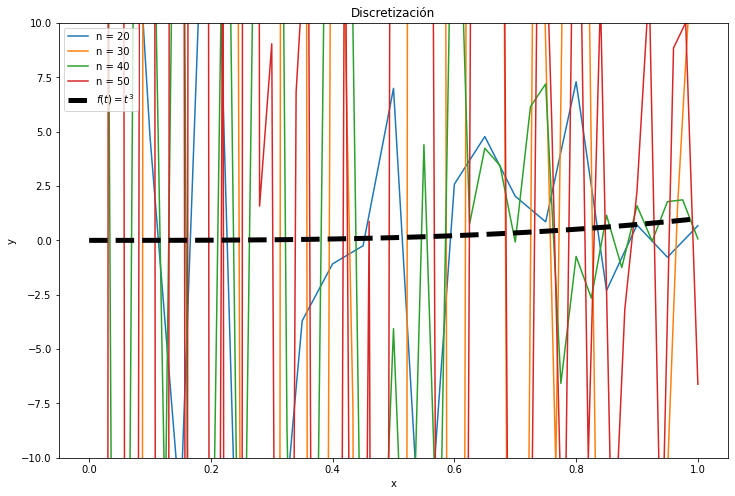

In [ ]:
plt.figure(figsize=(12,8))
for n in [20,30,40,50]:
  X = [(i/n) for i in range(1,n+1)]
  plt.plot(X,discretiza(n)[1],label=f"n = {n}")
X = np.arange(0,1,0.01)
Y = [f(x) for x in X]
plt.plot(X,Y,'k--',label=r"$f(t)=t^3$",linewidth=5)
plt.legend()
plt.title("Discretización")
plt.xlabel("x")
plt.ylabel("y")
plt.ylim((-10,10))
plt.show()

Al graficar se puede evidenciar que a pesar de que la partición aumenta las soluciones parecen no tener un límite definido, y mientras más grande se hace el tamaño de la partición no se observa una función límite.

La razón de esta falla al tratar de calcular la función por medio de discretización es el mal condicionamiento que tiene la matriz asociada al sistema discretizado. Para justificar el anterior enunciado se presenta la siguiente tabla que muestra la condición de la matriz $A$ para distintos tamaños de la partición.

In [ ]:
T0 = [[n,la.cond(discretiza(n)[0])] for n in range(20,100+1,10)]
print(tabulate(T0,headers=["Tamaño de la matriz","Numero de condición"],tablefmt="plain"))

  Tamaño de la matriz    Numero de condición
                   20            1.88232e+20
                   30            1.94915e+19
                   40            2.59885e+19
                   50            1.659e+19
                   60            3.06806e+19
                   70            1.28184e+20
                   80            7.56879e+19
                   90            1.47923e+20
                  100            5.12159e+19


La condición de la matriz es demasiado grande como para poder asegurar un aproximación lo suficientemente buena(en términos de residuo) a la solución real del problema. Cuando la partición de la matriz aumenta, la condición de la matriz asociada al problema discretizado parece estabilizarse en un intervalo de valores que para cuestiones prácticas son excesivamente grandes.

En las próximas secciones veremos métodos para arreglar el mal condicionamiento del problema discreto.

## Núcleo degenerado

En primer lugar, usamos el método de Trapecio para aproximar el valor de las integrales que se van a obtener en este apartado

In [ ]:
def Trapecio(f,a,b,n=10000):
  h = float((b-a)/n)
  n = int(n)
  T = [a+i*h for i in range(n+1)]
  Valor = (h/2)*(f(T[0]) + f(T[n])) + sum([(h)*f(T[k]) for k in range(1,n)])
  return(Valor)

Ahora, definimos la función que va a dar la solución a una ecuación integral con núcleo degenerado, es decir, un núcleo de la forma 
$$K(s,t)=\sum_{j=1}^{n}α_{j}(s)β_{j}(t)$$

Recordemos que si tenemos una ecuación de la forma
$$f(x)=g(x)+ \gamma \int_{a}^bK(x,y) f(y)dy, ~ \gamma\neq 0 $$
Entonces la solución a esta ecuación esta dada por 
$$f(x)=g(x)+\sum_{j=1}^{n}h_{j}\alpha_j(x)$$
donde $h$ es el vector que resuelve la ecuación
$$(\mathbf{I}-\gamma \mathbf{\Gamma})\mathbf{h}=\mathbf{g}
$$
en donde se definen
$$g_i=\gamma\int_{a}^b g(y)\beta_{i}(y)dy \quad\quad \gamma_{ij}=\int_{a}^b \alpha_j(y)\beta_i(y) dy $$

In [ ]:
def nucdeg(a,b,gamma,g,alpha,beta,M=10000):
  #[a,b] es el intervalo donde se define la integral en la ecuación de Volterra
  #gamma es el parámetro asociado a la ecuación
  #g es la función de la ecuación
  #alpha y beta son las funciones que componen el núcleo
  #M es el tamaño de la partición de [a,b] para hacer la integral numéricamente

  if len(alpha)!=len(beta):
    return("Error") #Warning
  n = len(alpha)

  #Matriz Gamma
  GA = np.array([[Trapecio(lambda x:(alpha[j](x)*beta[i](x)),a,b,M) for j in range(n)] for i in range(n)])
  #Vector g
  G = np.array([gamma*Trapecio(lambda x:(g(x)*beta[i](x)),a,b,M) for i in range(n)])
  
  A = np.identity(n)-gamma*GA
  h = la.solve(A,G)
  #Solución
  fsol = lambda x:(g(x)+sum([h[i]*alpha[i](x) for i in range(n)]))
  return(fsol)

Por ejemplo, si el nucleo de la ecuación es 
$K(s,t) = st$, $g(s)=s^2-s$, $[a,b]=[0,1]$ y $γ=4$ entonces la solución la ecuación de Volterra de segundo tipo es $f(s)=s^2$, esto se puede comprobar algoritmicamente como se muestra a continuación.

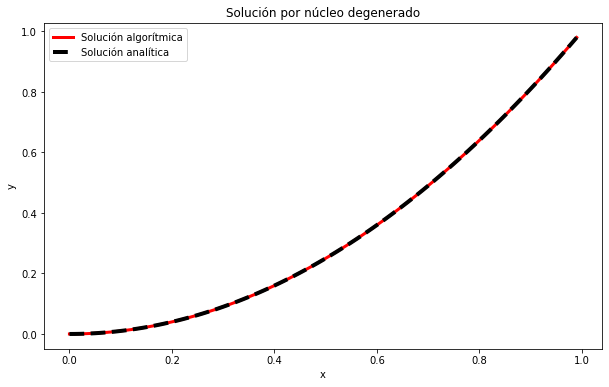

In [ ]:
#Definimos los argumentos para la función nucdeg
alpha = [lambda s:s]
beta = [lambda t:t]
g00 = lambda s:(s**2-s)
# Gráfica
f1 = nucdeg(0,1,4,g00,alpha,beta)
plt.figure(figsize=(10,6))
X = np.arange(0,1,0.01)
plt.plot(X,[f1(x) for x in X],'r',label='Solución algorítmica',linewidth=3)
plt.plot(X,[t**2 for t in X],'k--',label='Solución analítica',linewidth=4)
plt.title("Solución por núcleo degenerado")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Ambas lineas se superponen comprobando la utilidad y el buen funcionamiento del algoritmo.

## Regularización de Tikhonov

En esta sección se presentan dos métodos diferentes en los cuales se aplica regularización de Tikhonov para convertir el problema en otro problema con la importante propiedad de que el nuevo problema es bien condicionado.

En el siguiente método se propone primero realizar la discretización del problema para luego aplicar la regularización de Tikhonov.

In [ ]:
def disreg(a,b,K,g,n,delta,alpha=None):
  #Inputs
   #[a,b] es el intervalo donde se define la integral de la ecuación de Volterra
   # K es el kernel
   # g es la función conocida de la ecuación
   # n es tamaño de la partición para realizar la discretización
   # delta es el rango donde varía el ruido blanco agregado al vector g
   # alpha es el parámetro de Morozov
  
  #Discretización
  Particion = [a+(b-a)*(i/n) for i in range(1,n+1)]
  A = np.array([[K(i,j)/n for j in Particion] for i in Particion])
  b = np.array([g(i) for i in Particion])

  #Aleatorización de b
  b = b + np.random.uniform(-delta,delta,n)
  
  #Solución
  if alpha!=None: 
    #Si se conoce de antemano el valor de alpha 
    #se resuelve el sistema con este valor dado
    x = la.solve(np.transpose(A)@A + alpha*np.identity(n),np.transpose(A)@b)
    #La condición es el error en la distancia de Morozov
    cond = abs(la.norm(A@x-b,ord=np.inf)-delta)

    #Outputs
     #Solución discreta
     #Distancia de Morozov

    return((x,cond))
  if alpha==None:
    #Si el parámetro alpha no es dado entonces 
    #se minimiza la distancia de Morozov 
    def resMorozov(alpha):
      x = la.solve(np.transpose(A)@A + alpha*np.identity(n),np.transpose(A)@b)
      cond = abs(la.norm(A@x-b,ord=np.inf)-delta)
      return(cond)
    C = []
    for i in range(20):
      #Para hacer la optimización se toma un valor inicial de alpha aleatoriamente 
      #El proceso se repite 20 veces para poder tener más seguridad sobre la optimización
      alphapar = np.random.uniform(0,1)
      C.append(op.minimize(resMorozov,alphapar,method='Powell'))
    rmin = min([op.fun for op in C])
    # Se escoge el argumento que minimiza el residuo de Morozov
    alpha = float(C[[op.fun for op in C].index(rmin)].x)
    x = la.solve(np.transpose(A)@A + alpha*np.identity(n),np.transpose(A)@b)

    #Outputs
     #Solución discreta
     #Valor del parámetro alpha
     #Distancia de Morozov
    return((x,alpha,resMorozov(alpha)))

En la siguiente gráfica se prueba la efectividad del algoritmo para diferentes tamaños de la partición.

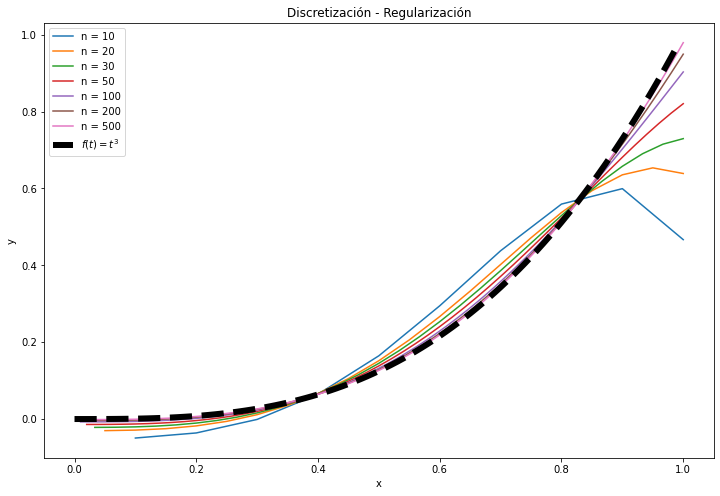

In [ ]:
plt.figure(figsize=(12,8))
T3 = []
for n in [10,20,30,50,100,200,500]:
  X = [(i/n) for i in range(1,n+1)]
  start = time.time()
  l3 = disreg(0,1,K,g,n,1e-5)
  end = time.time()
  res = la.norm(np.array([f(x) for x in X])-l3[0],ord=np.inf)
  T3.append([n,end-start,res])
  plt.plot(X,l3[0],label=f"n = {n}")
X = np.arange(0,1,0.01)
Y = [f(x) for x in X]
plt.plot(X,Y,'k--',label=r"$f(t)=t^3$",linewidth=6)
plt.legend()
plt.title("Discretización - Regularización")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

En comparación con la gráfica obtenida cuando solo se aplica discretización, en este caso se puede evidenciar la mejora en el comportamiento de la aproximación de la función solución, también es notable la mejora que se obtiene al aumentar el tamaño de la discretización. Debe tenerse en cuenta que no siempre se obtiene la misma aproximación a la función dado que el *ruido blanco* cambia cada vez que se ejecuta el método (estamos suponiendo que los datos presentan contaminación que mediante la aleatorización del vector podemos corregir).

El tiempo de ejecución y residuo en norma infinito son los siguientes

In [ ]:
print(tabulate(T3,headers=("n","Tiempo de ejecución(seg)","Residuo(norma infinito)"),tablefmt="plain"))

  n    Tiempo de ejecución(seg)    Residuo(norma infinito)
 10                    0.433623                  0.533233
 20                    1.04975                   0.3611
 30                    0.951015                  0.270379
 50                    1.47205                   0.179465
100                    3.34854                   0.0968652
200                   10.9744                    0.0506083
500                   91.6211                    0.0207057


En esta segunda parte, nos proponemos primero aplicar regularización obteniendo una ecuación integral de segundo grado, luego hacer discretización del kernel para convertirlo en un kernel degenerado (esto es posible gracias a que el kernel es una integral) y poder aplicar el algoritmo que se presento anteriormente.

In [ ]:
def regdis(a,b,K,g,n,delta=None,alpha=None):
  #Inputs
   #[a,b] es el intervalo donde se define la integral de la ecuación de Volterra
   # K es el kernel
   # g es la función conocida de la ecuación
   # n es tamaño de la partición para realizar la discretización
   # delta es el rango donde varía el ruido blanco agregado al vector g
   # alpha es el parámetro de Morozov
  
  #Discretizamos el operador (K* K)
  Particion = [a+ (b-a)*(i/n) for i in range(1,n+1)]
  Kbeta = [lambda s:((1/n)*K(p,s)) for p in Particion]
  Kalpha = [lambda t:(K(p,t)) for p in Particion]

  def g0(s): 
    #Aleatorización del vector
    g1 = lambda u:(K(u,s)*g(u) + np.random.uniform(-delta,delta))
    return(Trapecio(g1,a,b,25))
    #Cuidado: Esta función está definida como una integral que es realizada por medio de
    #integración numérica, el tiempo en que gasta en calcularse esta función es proporcional
    #al tamaño de la partición con la que se ejecute.
  

  def resMorozov(alp):
      f0 = nucdeg(a,b,-1/alp,g0,Kalpha,Kbeta,25)
      f1 = lambda x:((1/alp)*f0(x))
      Kf1 = lambda x:(Trapecio(lambda y:(K(x,y)*f1(y)),a,b,25))
      X = np.arange(a,b,0.05)
      err = max([abs(Kf1(x)-g(x)) for x in X])
      return(err)
  
  if alpha!=None:
    #Si se conoce de antemano el valor de alpha 
    #se resuelve el sistema con este valor dado
    f = nucdeg(a,b,-1/alpha,g0,Kalpha,Kbeta,1000)
    X = np.arange(a,b,0.01)
    cond = resMorozov(alpha)

    #Outputs
     #Solución discreta
     #Valor del parámetro alpha
     #Distancia de Morozov
    
    return((lambda x:((1/alpha)*f(x)),alpha,cond))
  if alpha==None:
    #Si el parámetro alpha no es dado entonces se minimiza la distancia de Morozov 
    #Para hacer la optimización se toma un valor inicial de alpha aleatoriamente 
    #El proceso se repite 2 veces para poder tener un poco de más seguridad sobre la optimización
    
    C = []
    for i in range(2):
      alphapar = np.random.uniform(0.01,5)
      C.append(op.minimize(resMorozov,alphapar,method='Powell'))
    rmin = min([op.fun for op in C])
    # Se escoge el argumento que minimiza el residuo de Morozov
    alpha = float(C[[op.fun for op in C].index(rmin)].x)
    f = nucdeg(a,b,-1/alpha,g0,Kalpha,Kbeta,1000)

    #Outputs
     #Solución discreta
     #Valor del parámetro alpha óptimo
     #Distancia de Morozov

    return((lambda x:((1/alpha)*f(x)),alpha,resMorozov(alpha)))

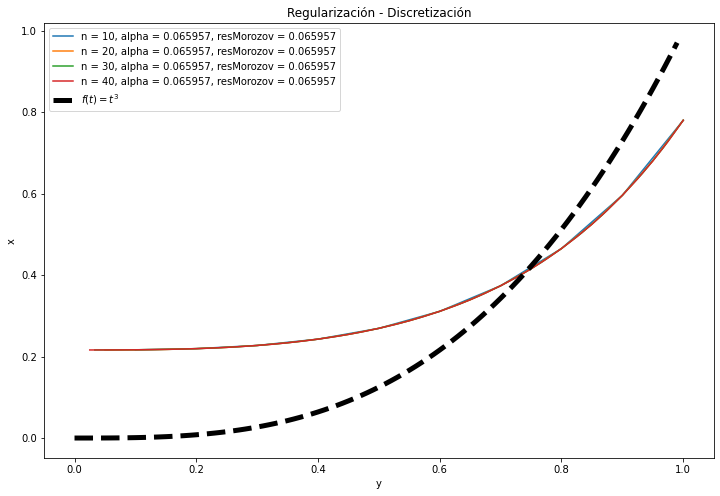

In [ ]:
#Gráfica
plt.figure(figsize=(12,8))
T4 = []
for n in [10,20,30,40]:
  X = [(i/n) for i in range(1,n+1)]
  start = time.time()
  l4 = regdis(0,1,K,g,n,1e-5)
  end = time.time()
  res = la.norm(np.array([f(x) for x in np.arange(0,1,0.05)])-np.array([l4[0](x) for x in np.arange(0,1,0.05)]),ord=np.inf)
  T4.append([n,end-start,res])
  plt.plot(X,[l4[0](x) for x in X],label=f"n = {n}, alpha = {l[1]:.06f}, resMorozov = {l[2]:.06f}")
X = np.arange(0,1,0.01)
Y = [f(x) for x in X]
plt.plot(X,Y,'k--',label=r"$f(t)=t^3$",linewidth=5)
plt.legend()
plt.title("Regularización - Discretización")
plt.xlabel("y")
plt.ylabel("x")
plt.show()

Los criterios de evaluación de este método son presentados en la tabla a continuación.

In [ ]:
print(tabulate(T4,headers=("n","Tiempo de ejecución(seg)","Residuo(norma infinito)"),tablefmt="plain"))

  n    Tiempo de ejecución(seg)    Residuo(norma infinito)
 10                     44.4944                   0.216147
 20                     66.6651                   0.216146
 30                     90.0799                   0.216146
 40                    144.44                     0.216146


En comparación, los métodos basados en regularización presentan ventajas respecto al ajuste a la solución esperada; para este caso el método que mejor se ajusta a la solución es *Discretización-Regularización*.
Computacionalmente ambos métodos son costosos en el sentido de que ejecutar cada uno de estos métodos requiere una cantidad alta de tiempo en contraste con los demás métodos. 

## Métodos iterativos

En esta sección solo se trabaja el método de iteración de Landweber. El metodo consiste en discretizar el problema, luego de esto aplicar un método similar a regularización con un componente adicional que depende de cierto parámetro en este caso llamado $β$.

In [ ]:
def Landweber(a,b,K,g,n,delta,eps=0.1,M=100000,x=None):
  #Inputs 
   #[a,b] es el intervalo donde se realiza la integral
   #K es el kernel 
   # g es la función conocida
   # n es el tamaño de la partición para hacer la discretización
   # delta es el rango donde varía el ruido blanco agregado al vector g
   # eps es el epsolon de tolerancia para detener la iteración
   # M es el máximo de número de iteraciones
   # x es el vector para inicial la iteración 

  if x == None:
    x = np.zeros(n)
  
  #Discretización
  Particion = [a+(b-a)*(i/n) for i in range(1,n+1)]
  A = np.array([[K(i,j)/n for j in Particion] for i in Particion])
  b = np.array([g(i)+np.random.uniform(-delta,delta) for i in Particion])

  #Radio espectral de A
  lam = max([abs(x) for x in la.eigvals(np.transpose(A)@A)])

  #Se escoge el parámetro beta aleatoriamente
  beta = np.random.uniform(0,2/lam)
  
  #Iteración
  for i in range(M):
    x += beta*(np.transpose(A)@b-np.transpose(A)@A@x)
    if la.norm(A@x-b,ord=np.inf)<=eps:
      #Output
        #Vector 
      return(x)
  print(f"Máximo de iteraciones alcanzado. n = {n} ") #Warning: Posible no convergencia del método
  #Output
    #Vector
  return(x)

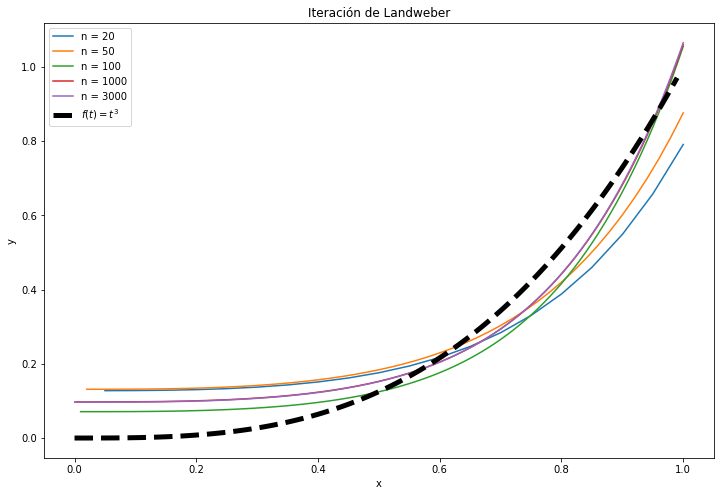

In [ ]:
#Gráfica
plt.figure(figsize=(12,8))
T5 = []
for n in [20,50,100,1000,3000]:
  X = [(i/n) for i in range(1,n+1)]
  start = time.time()
  l5 = Landweber(0,1,K,g,n,1e-4,0.01)
  end = time.time()
  res = la.norm(np.array([f(x) for x in X])-l5,ord=np.inf)
  T5.append([n,end-start,res])
  plt.plot(X,l5,label=f"n = {n}")
X = np.arange(0,1,0.01)
Y = [f(x) for x in X]
plt.plot(X,Y,"k--",label=r"$f(t)=t^3$",linewidth=5)
plt.legend()
plt.title("Iteración de Landweber")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

El tiempo de ejecución en segundos y el residuo de la solución algorítmica respecto a la solución teorica son presentados en la siguiente tabla.

In [ ]:
print(tabulate(T5,headers=("n","Tiempo de ejecución(seg)","Residuo(norma infinito)"),tablefmt="plain"))

   n    Tiempo de ejecución(seg)    Residuo(norma infinito)
  20                  0.00118685                  0.209361
  50                  0.00481319                  0.133072
 100                  0.0544214                   0.09573
1000                 21.0616                      0.0972184
3000                 73.6322                      0.096547


## TSVD

Con ayuda de la librería *Numpy* realizamos el método de descomposición en valores singulares truncada aplicada a la matriz obtenida después de discretizar el problema.

In [ ]:
def tsvd(a,b,K,g,n,m,delta):
  #Inputs 
   #[a,b] es el intervalo donde se realiza la integral
   #K es el kernel 
   # g es la función conocida
   # n es el tamaño de la partición para hacer la discretización
   # m es el valor en donde truncar la serie
   # delta es el rango donde varía el ruido blanco agregado al vector de g


  #Discretización
  Particion = [a+(b-a)*(i/n) for i in range(1,n+1)]
  A = np.array([[K(i,j)/n for j in Particion] for i in Particion])
  b = np.array([g(i)+np.random.uniform(-delta,delta) for i in Particion])

  #Descomposición en valores singulares de la matriz A (SVD)
  U,S,Vh = la.svd(A)

  #Truncamiento de la serie
  x = sum([(np.inner(b,U[:,i])/S[i])*Vh[i,:] for i in range(m)])

  #Outputs
    #Vector solución
  return(x)

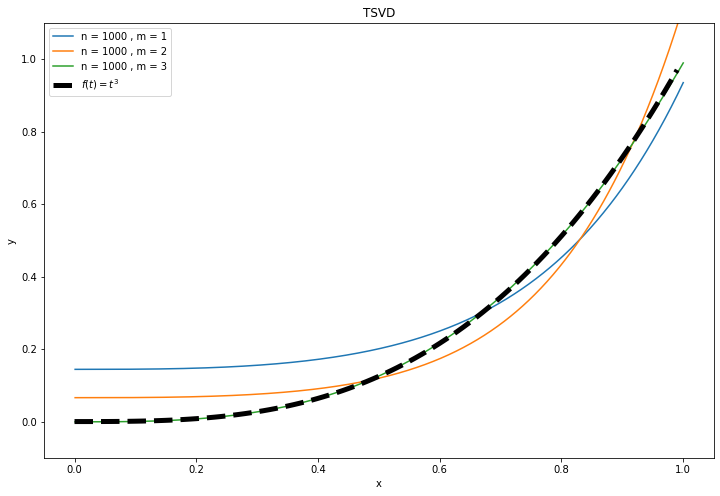

In [ ]:
#Gráfica
plt.figure(figsize=(12,8))
T6 = []
for n in [1000]:
  for m in [1,2,3]:
    X = [(i/n) for i in range(1,n+1)]
    start = time.time()
    l6 = tsvd(0,1,K,g,n,m,1e-5)
    end = time.time()
    res = la.norm(np.array([f(x) for x in X])-l6,ord=np.inf)
    T6.append([n,m,end-start,res])
    plt.plot(X,l6,label=f"n = {n} , m = {m}")
X = np.arange(0,1,0.01)
Y = [f(x) for x in X]
plt.plot(X,Y,'k--',label=r"$f(t)=t^3$",linewidth=5)
plt.legend()
plt.title("TSVD")
plt.xlabel("x")
plt.ylabel("y")
plt.ylim((-0.1,1.1))
plt.show()

Veamos otra forma de representar las soluciones obtenidas por este metodo

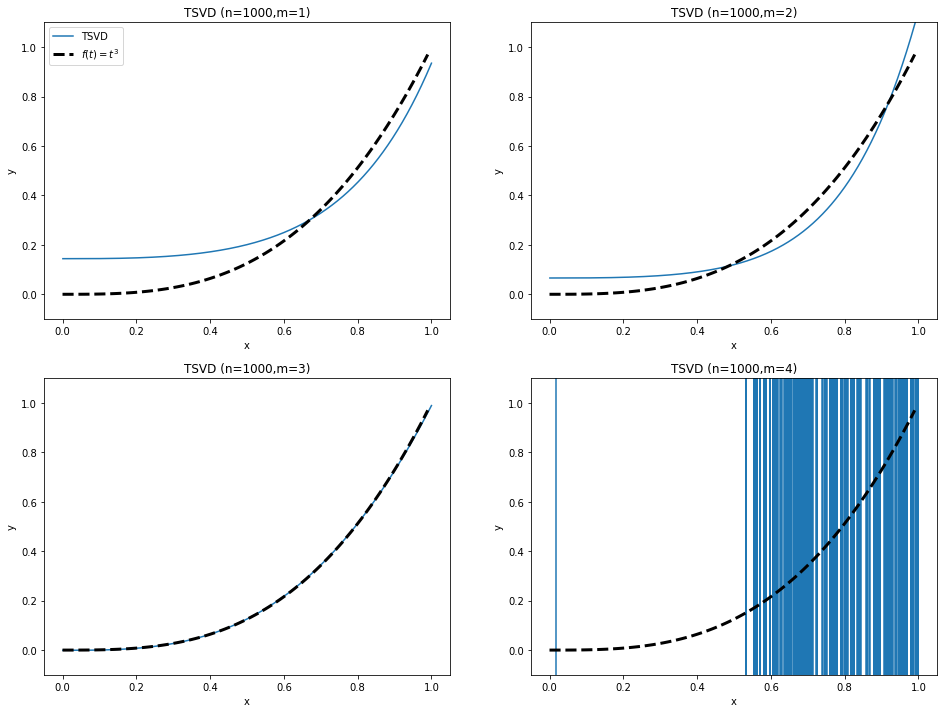

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(16,12))
X = [(i/1000) for i in range(1,1000+1)]
ax[0,0].plot(X,tsvd(0,1,K,g,1000,1,1e-5),label="TSVD")
ax[0,0].plot(np.arange(0,1,0.01),[f(x) for x in np.arange(0,1,0.01)],'k--',label="$f(t)=t^3$",linewidth=3)
ax[0,0].set_title("TSVD (n=1000,m=1)")
ax[0,0].set(xlabel="x",ylabel="y")
ax[0,0].set_ylim(-0.1,1.1)
ax[0,0].legend()

ax[0,1].plot(X,tsvd(0,1,K,g,1000,2,1e-5),label="TSVD")
ax[0,1].plot(np.arange(0,1,0.01),[f(x) for x in np.arange(0,1,0.01)],'k--',label="$f(t)=t^3$",linewidth=3)
ax[0,1].set_title("TSVD (n=1000,m=2)")
ax[0,1].set(xlabel="x",ylabel="y")
ax[0,1].set_ylim(-0.1,1.1)
ax[0,0].legend()

ax[1,0].plot(X,tsvd(0,1,K,g,1000,3,1e-5),label="TSVD")
ax[1,0].plot(np.arange(0,1,0.01),[f(x) for x in np.arange(0,1,0.01)],'k--',label="$f(t)=t^3$",linewidth=3)
ax[1,0].set_title("TSVD (n=1000,m=3)")
ax[1,0].set(xlabel="x",ylabel="y")
ax[1,0].set_ylim(-0.1,1.1)
ax[0,0].legend()

ax[1,1].plot(X,tsvd(0,1,K,g,1000,4,1e-5),label="TSVD")
ax[1,1].plot(np.arange(0,1,0.01),[f(x) for x in np.arange(0,1,0.01)],'k--',label="$f(t)=t^3$",linewidth=3)
ax[1,1].set_title("TSVD (n=1000,m=4)")
ax[1,1].set(xlabel="x",ylabel="y")
ax[1,1].set_ylim(-0.1,1.1)
ax[0,0].legend()

plt.show()

Es notable que cuando ejecutamos el método con un tamaño de discretización de tamaño $n=1000$ y una serie truncada hasta $m\geq 4$ perdemos la precisión que aparenta poseer cuando solo truncamos la serie hasta $m\leq 4$. También, cabe destacar que al aplicar el método cuando $m=3$ presenta una ajuste a la curva solución tan bueno que la diferencia entre la solución algorítmica y la solución teórica es imperceptible a simple vista.

El error y el tiempo que se demora en ejecutarse este método se presentan en la siguiente tabla.

In [ ]:
print(tabulate(T6,headers=("n","m","Tiempo de ejecución(seg)","Residuo(norma infinito)"),tablefmt="plain"))

   n    m    Tiempo de ejecución(seg)    Residuo(norma infinito)
  10    1                 0.00061655                 0.32563
  10    2                 0.000407696                0.355271
  10    3                 0.000472784                0.533619
  10    4                 0.000358582                1.31508e+11
 100    1                 0.0168912                  0.141029
 100    2                 0.0235028                  0.0910022
 100    3                 0.0286801                  0.0970359
 100    4                 0.0228519                  2.33791e+10
1000    1                 1.95932                    0.144081
1000    2                 1.82244                    0.146261
1000    3                 2.04617                    0.0103106
1000    4                 2.80026                    2.3008e+09


# Aplicaciones

## Análisis de imagen en una dimensión

Considere la función $g$ que representa la imagen desenfocada y el kernel de la ecuación integral $k(y)$ donde $y=x-x'$, esta función representa los fenómenos que afectan la calidad y nitidez de la imagen

In [ ]:
def g(x):
  return(x)
def ker(y):
  return(np.exp(y**2))

Para resolver la ecuación integral lo que hacemos es realizar un proceso de discretización, es decir, tomamos una serie de puntos en un intervalo de interés, en este caso, en el conjunto $[0,1]×[0,1]$ y luego, tratamos la integral como si fuese una sumatoria de Riemann (pensamos que la función $f$ que queremos hallar es el límite de la solución de los sistemas discretos).

A continuación, mostramos la solución al sistema de ecuaciones lineales obtenido luego del proceso de discretización de la ecuación integral

In [ ]:
def K_1d(n):
  K = np.array([[(1/n)*ker((i-j)*(1/n)) for j in range(n+1)] for i in range(n+1)])
  f = la.solve(K,np.array([g(x) for x in range(n+1)]))
  return((f,K))

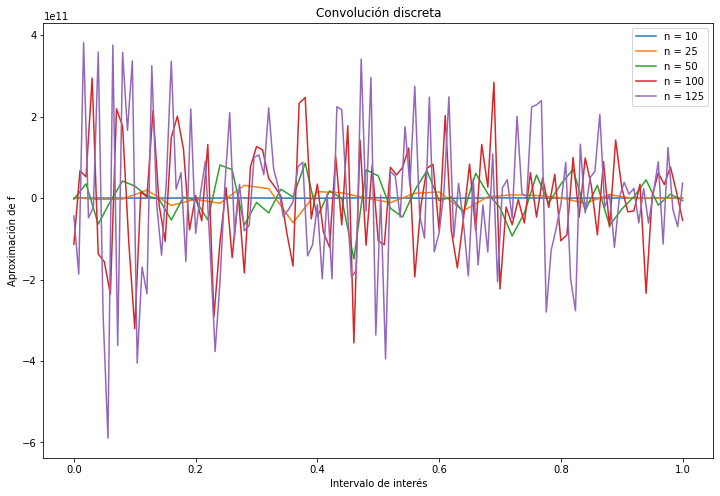

In [ ]:
plt.figure(figsize=(12,8))
for n in [10,25,50,100,125]:
  X = [(i/n) for i in range(n+1)]
  plt.plot(X,K_1d(n)[0],label=f"n = {n}")
plt.legend()
plt.title("Convolución discreta")
plt.xlabel("Intervalo de interés")
plt.ylabel("Aproximación de f")
plt.show()

El anterior gráfico demuestra el mal condicionamiento de este problema inverso. Las funciones no parecen tener un límite que parezca intuitivo. Otra forma de observar este problema es notar una alta condición de la matriz de discretización la cual se presenta en la siguiente tabla

In [ ]:
T0 = [[n,la.cond(K_1d(n)[1])] for n in range(5,125+1,5)]
print(tabulate(T0,headers=["Tamaño de la matriz","Numero de condición"],tablefmt="plain"))

  Tamaño de la matriz    Numero de condición
                    5            4.92945e+06
                   10            2.96428e+16
                   15            9.23419e+16
                   20            3.80108e+18
                   25            2.27941e+19
                   30            3.94965e+19
                   35            4.1733e+18
                   40            2.10726e+21
                   45            1.50623e+19
                   50            3.13751e+18
                   55            1.42592e+19
                   60            5.87139e+20
                   65            1.48225e+19
                   70            9.25666e+18
                   75            2.60727e+19
                   80            2.59695e+19
                   85            1.37697e+19
                   90            5.47244e+18
                   95            1.65538e+19
                  100            1.35047e+19
                  105            1.61438e+19
           

#Referencias



1.   Groetsch, C. W. (2014). Inverse problems in the mathematical sciences. Vieweg & Teubner. \
2.   Vogel, C. R. (2002). Computational methods for inverse problems. Society for Industrial and Applied Mathematics.

